<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/DIABETES_PREDICTION_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Importing Libraries</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imbalanced-learn
!pip install ydata_profiling


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.layers import Input, LSTM, Dropout, Dense
from keras.models import Model

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Load The Dataset</p>

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset1.csv')

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Exploratory Data Analysis(EDA)</p>

In [ ]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'HbA1c_level', 'blood_glucose_level', 'Outcome'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  100000 non-null  float64
 1   hypertension         100000 non-null  int64  
 2   heart_disease        100000 non-null  int64  
 3   smoking_history      100000 non-null  int64  
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   Outcome              100000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 6.1 MB


In [ ]:
df.describe()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,Outcome
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,0.544560,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,0.498013,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,1.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
df.isnull().sum()

,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
Outcome,0


In [ ]:
print(df.columns)

Index(['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'HbA1c_level', 'blood_glucose_level', 'Outcome'],
      dtype='object')


In [ ]:
df['Outcome'].value_counts()

,count
Outcome,
0,91500
1,8500


<Axes: xlabel='Outcome', ylabel='count'>

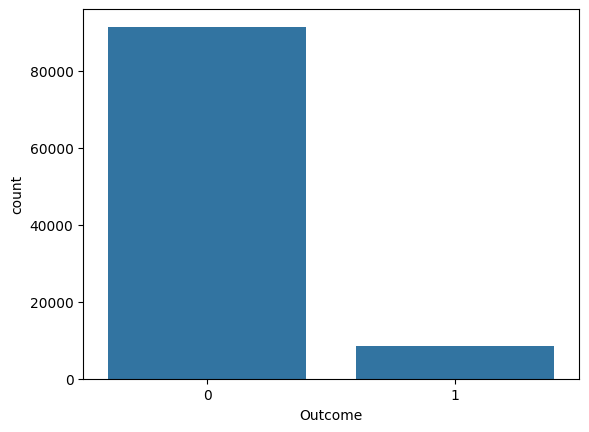

In [ ]:
sns.countplot(x = df['Outcome'])

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Pandas Profiling</p>

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 14.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Correlation Analysis</p>

Correlations with Outcome:
blood_glucose_level    0.419558
HbA1c_level            0.400660
age                    0.258008
bmi                    0.214357
hypertension           0.197823
heart_disease          0.171727
smoking_history        0.045848
Name: Outcome, dtype: float64


<ipython-input-13-e76549f2922b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlations.index, y=sorted_correlations.values, palette='coolwarm')


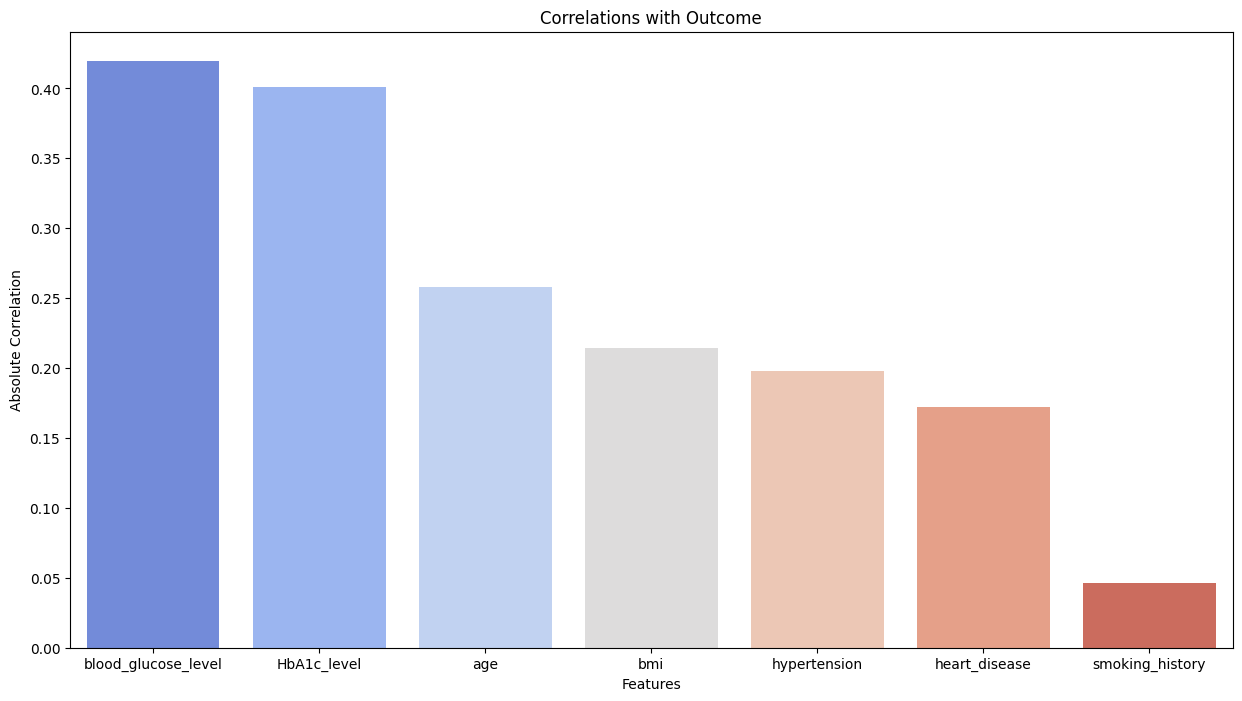

In [ ]:
# Select only numeric features for correlation analysis
numeric_features = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_features.corr()

# Continue with the rest of your code
outcome_correlations = correlation_matrix['Outcome'].drop('Outcome')  # Drop the Outcome column itself
sorted_correlations = outcome_correlations.abs().sort_values(ascending=False)
print("Correlations with Outcome:")
print(sorted_correlations)

plt.figure(figsize=(15, 8))
sns.barplot(x=sorted_correlations.index, y=sorted_correlations.values, palette='coolwarm')
plt.title('Correlations with Outcome')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.show()

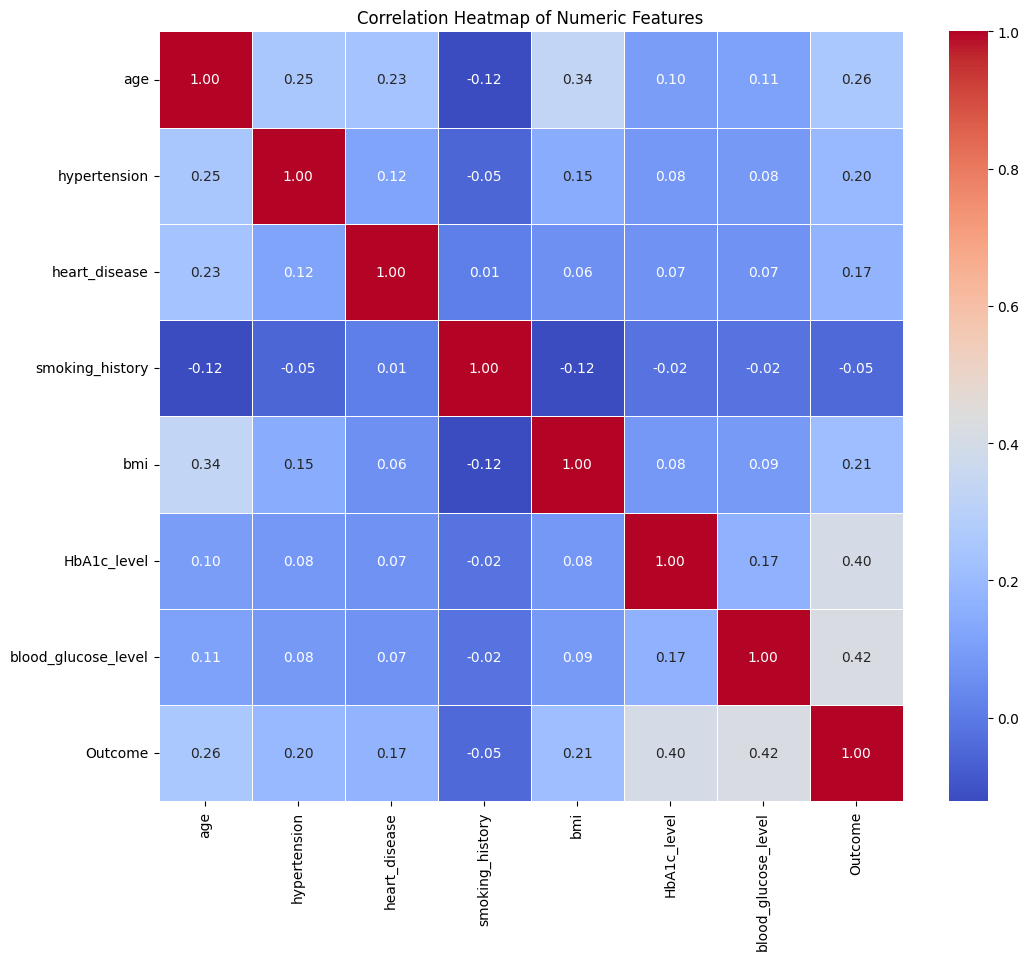

In [ ]:


# Select only numeric features for correlation analysis
numeric_features = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_features.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Train-Test-Split</p>

In [ ]:
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">Feature Standardization</p>

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#FF5C19; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FF5C19">LSTM</p>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2000/2000 - 14s - 7ms/step - accuracy: 0.9258 - loss: 0.2109 - val_accuracy: 0.9334 - val_loss: 0.1798
Epoch 2/50
2000/2000 - 16s - 8ms/step - accuracy: 0.9414 - loss: 0.1587 - val_accuracy: 0.9537 - val_loss: 0.1357
Epoch 3/50
2000/2000 - 6s - 3ms/step - accuracy: 0.9456 - loss: 0.1469 - val_accuracy: 0.9588 - val_loss: 0.1198
Epoch 4/50
2000/2000 - 10s - 5ms/step - accuracy: 0.9477 - loss: 0.1416 - val_accuracy: 0.9579 - val_loss: 0.1206
Epoch 5/50
2000/2000 - 11s - 5ms/step - accuracy: 0.9497 - loss: 0.1376 - val_accuracy: 0.9527 - val_loss: 0.1309
Epoch 6/50
2000/2000 - 6s - 3ms/step - accuracy: 0.9504 - loss: 0.1343 - val_accuracy: 0.9594 - val_loss: 0.1147
Epoch 7/50
2000/2000 - 10s - 5ms/step - accuracy: 0.9524 - loss: 0.1314 - val_accuracy: 0.9493 - val_loss: 0.1391
Epoch 8/50
2000/2000 - 6s - 3ms/step - accuracy: 0.9534 - loss: 0.1280 - val_accuracy: 0.9576 - val_loss: 0.1153
Epoch 9/50
2000/2000 - 6s - 3ms/step - accuracy: 0.9535 - loss: 0.1269 - val_accuracy: 0.96

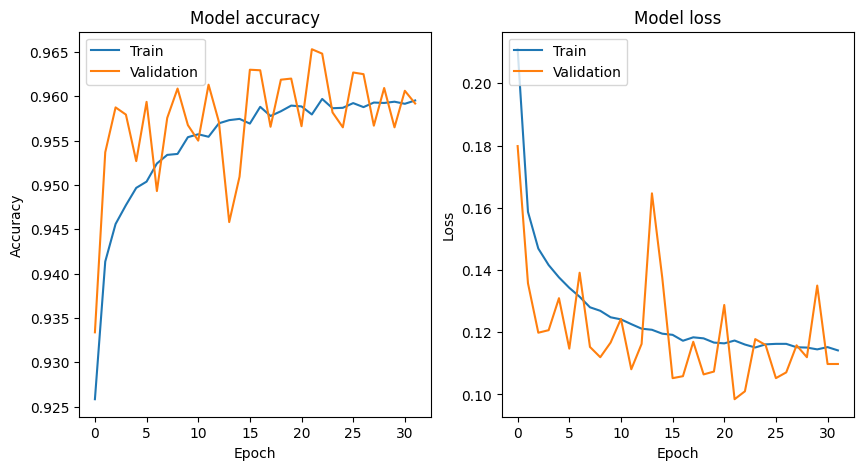

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM Accuracy: 0.96

LSTM Confusion Matrix:
[[18274    18]
 [  794   914]]

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18292
           1       0.98      0.54      0.69      1708

    accuracy                           0.96     20000
   macro avg       0.97      0.77      0.84     20000
weighted avg       0.96      0.96      0.95     20000



In [ ]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dropout, Dense
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping # Add this for early stopping functionality


X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # Adjust patience as needed

# Fit the model and store the history
history = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=2,
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


lstm_pred_proba = lstm_model.predict(X_test_lstm)
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred_proba]
lstm_accuracy = accuracy_score(y_test, lstm_pred)
print(f"LSTM Accuracy: {lstm_accuracy:.2f}")

lstm_conf_matrix = confusion_matrix(y_test, lstm_pred)
lstm_classification_report = classification_report(y_test, lstm_pred)

print("\nLSTM Confusion Matrix:")
print(lstm_conf_matrix)
print("\nLSTM Classification Report:")
print(lstm_classification_report)

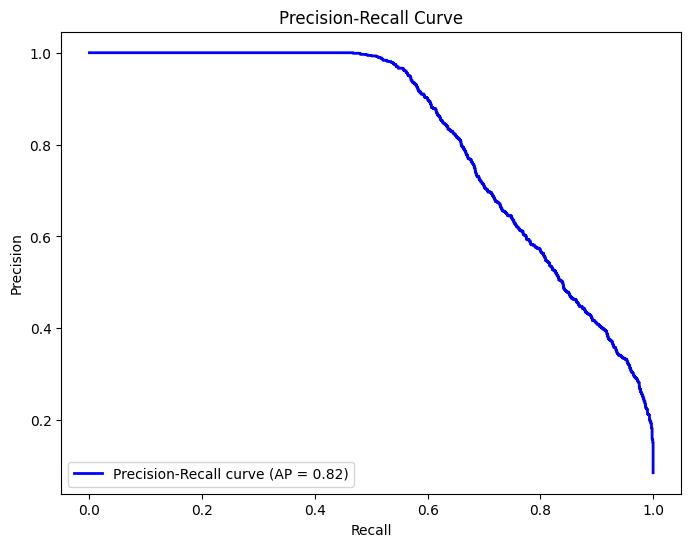

In [ ]:
# Import necessary functions from sklearn.metrics
from sklearn.metrics import precision_recall_curve, average_precision_score


# Calculate precision-recall curve and average precision
precision, recall, thresholds = precision_recall_curve(y_test, lstm_pred_proba)
average_precision = average_precision_score(y_test, lstm_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


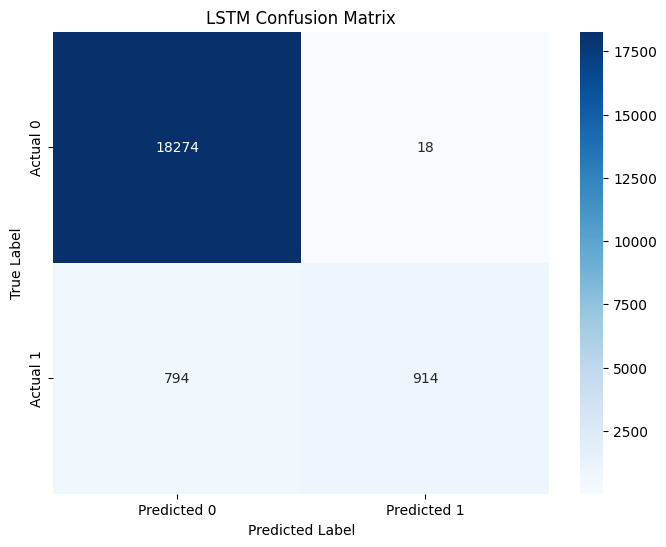

In [ ]:
# After fitting the LSTM model and making predictions:
lstm_pred_proba = lstm_model.predict(X_test_lstm)
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred_proba]

# Calculate the confusion matrix
lstm_conf_matrix = confusion_matrix(y_test, lstm_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


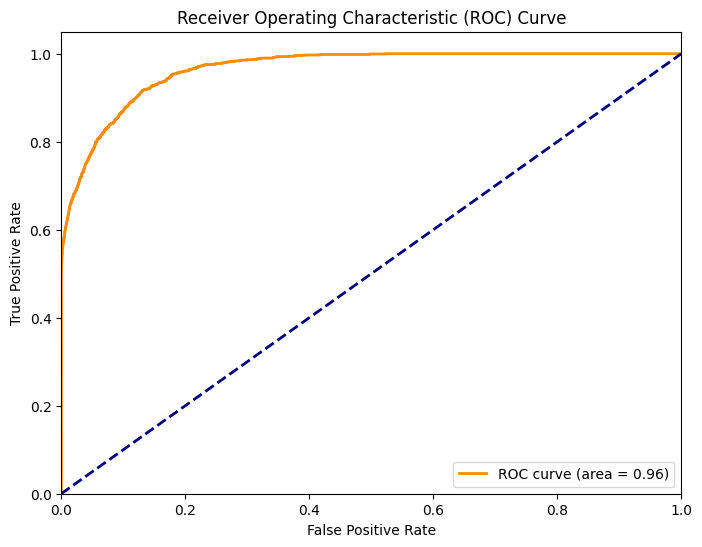

In [ ]:
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities for the positive class
lstm_pred_proba = lstm_model.predict(X_test_lstm)[:, 0]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, lstm_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


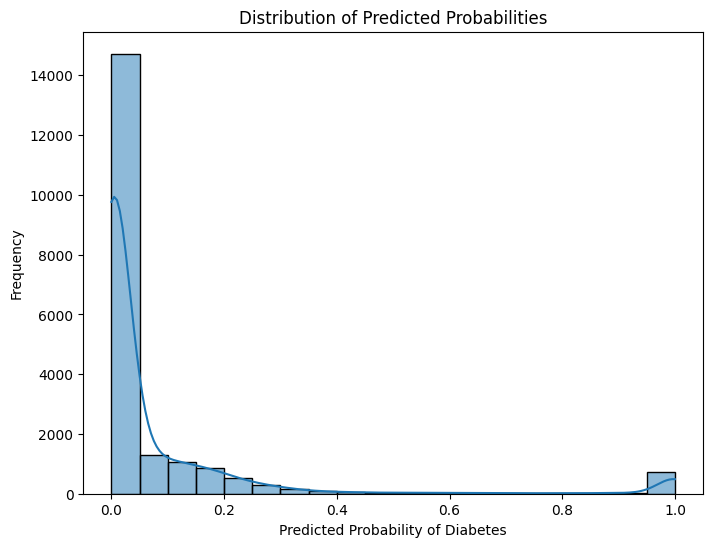

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for the positive class
lstm_pred_proba = lstm_model.predict(X_test_lstm)[:, 0]

# Plot the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
sns.histplot(lstm_pred_proba, bins=20, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Diabetes')
plt.ylabel('Frequency')
plt.show()

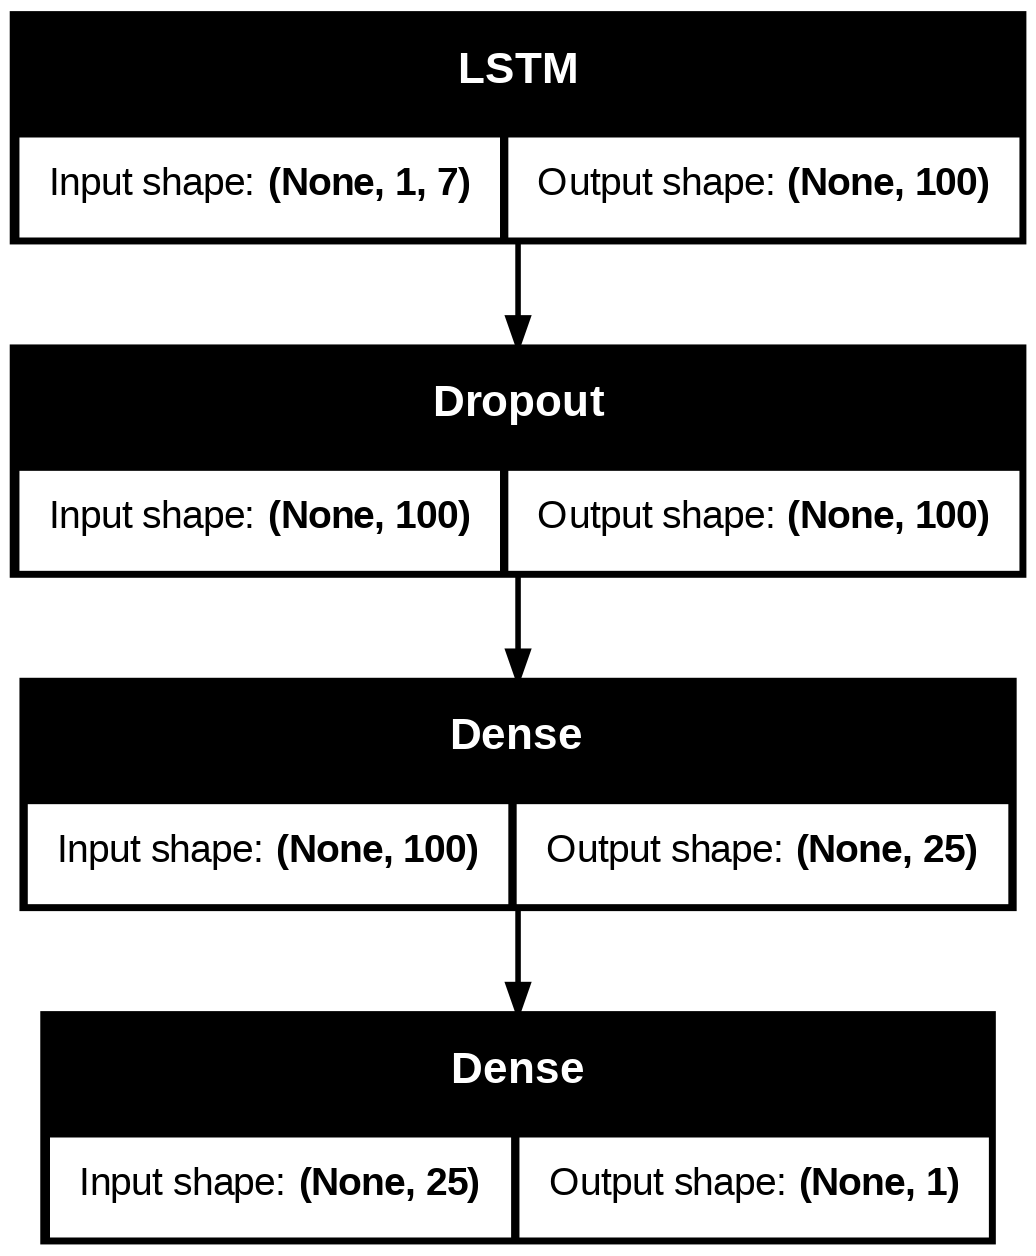

In [ ]:
from tensorflow.keras.utils import plot_model # Import plot_model from the correct location

plot_model(lstm_model, to_file='model_plot.png', show_shapes=True)

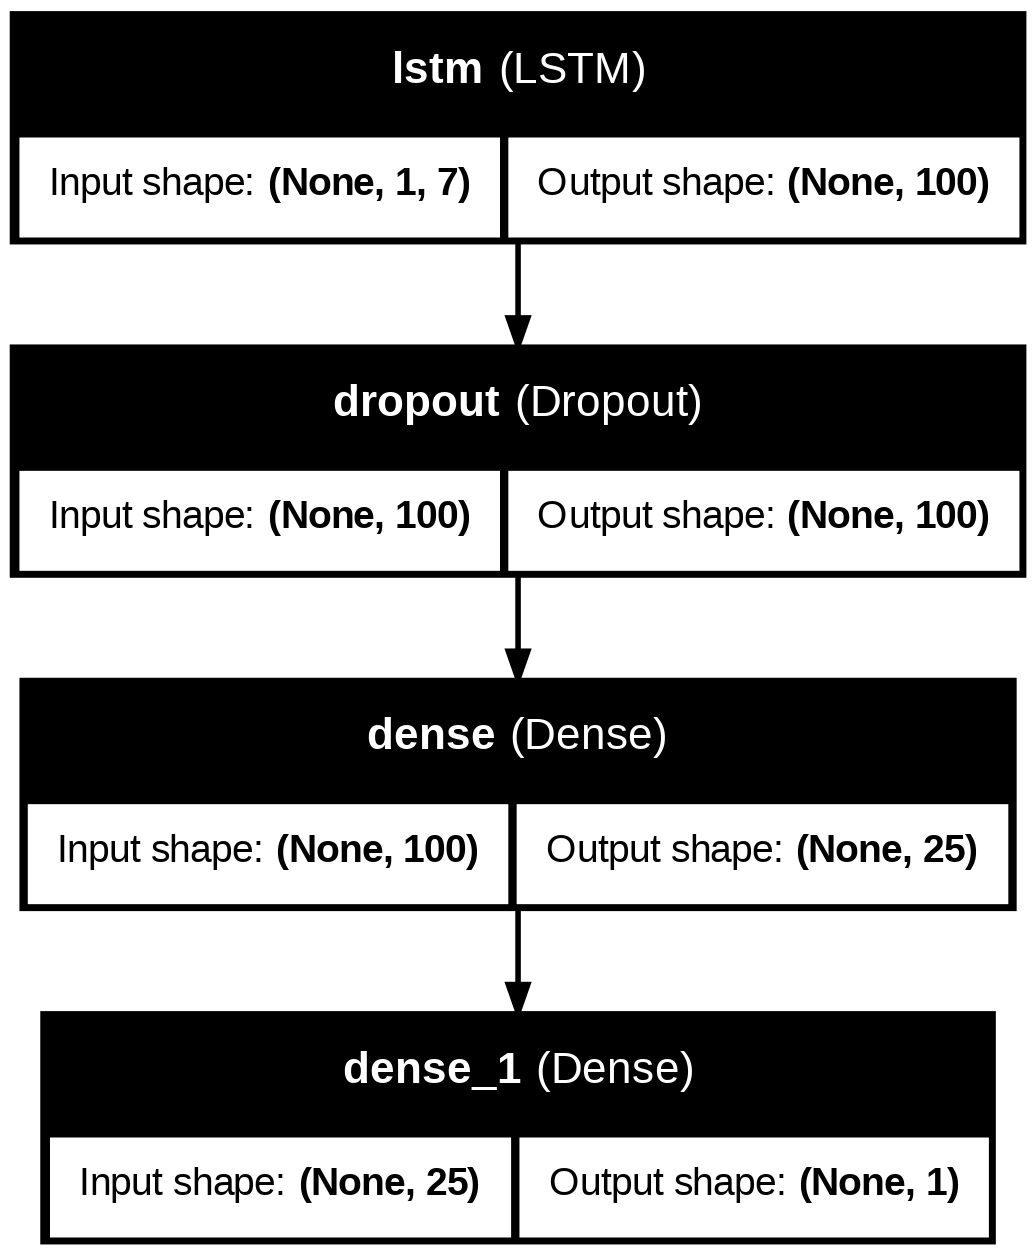

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(lstm_model, to_file='lstm_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,504 (357.44 KB)

 Trainable params: 45,751 (178.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,753 (178.73 KB)

In [ ]:
lstm_pred_proba = lstm_model.predict(X_test_lstm)
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred_proba]

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
!pip install diagrams

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 32.0 MB/s eta 0:00:00


In [ ]:
from diagrams import Diagram, Cluster, Edge
from diagrams.custom import Custom
from diagrams.gcp.compute import ComputeEngine
from diagrams.onprem.database import PostgreSQL
from diagrams.onprem.client import User  # Import User from diagrams.onprem.client


with Diagram("LSTM Model Flowchart", show=False):
    # Input Data
    input_data = PostgreSQL("Input Data")

    # Reshaping
    reshape = ComputeEngine("Reshaping (samples, timesteps, features)")

    # LSTM Layer
    lstm_layer = Custom("LSTM Layer (100 units)", "lstm_icon.png")  # Replace with actual icon path if needed

    # Dropout
    dropout = Custom("Dropout (0.2)", "dropout_icon.png")  # Replace with actual icon path if needed

    # Dense Layers
    dense_25 = ComputeEngine("Dense Layer (25 units, ReLU)")
    dense_1 = ComputeEngine("Dense Layer (1 unit, Sigmoid)")

    # Output/Prediction
    output = User("Prediction (0 or 1)")

    # Data Flow
    input_data >> reshape >> lstm_layer >> dropout >> dense_25 >> dense_1 >> output

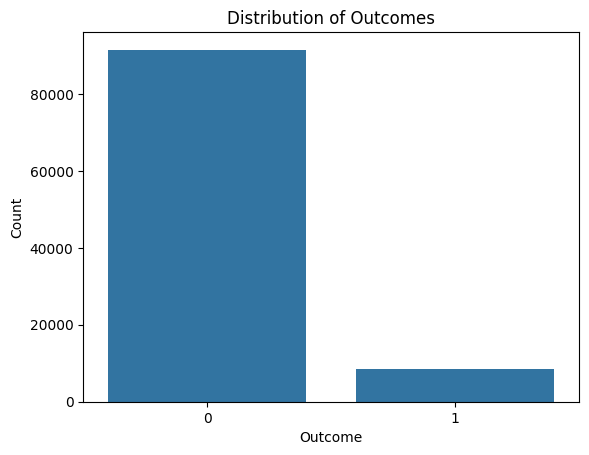

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Outcome' is the target variable column
sns.countplot(x=df['Outcome'])
plt.title('Distribution of Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

In [ ]:
# Assuming you want to use a RandomForestClassifier as your tree-based model
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
model = RandomForestClassifier(random_state=42)  # Initialize the model
model.fit(X_train, y_train)  # Train the model on your training data

# Now you can access feature importances
importances = model.feature_importances_
# ... rest of your code ...

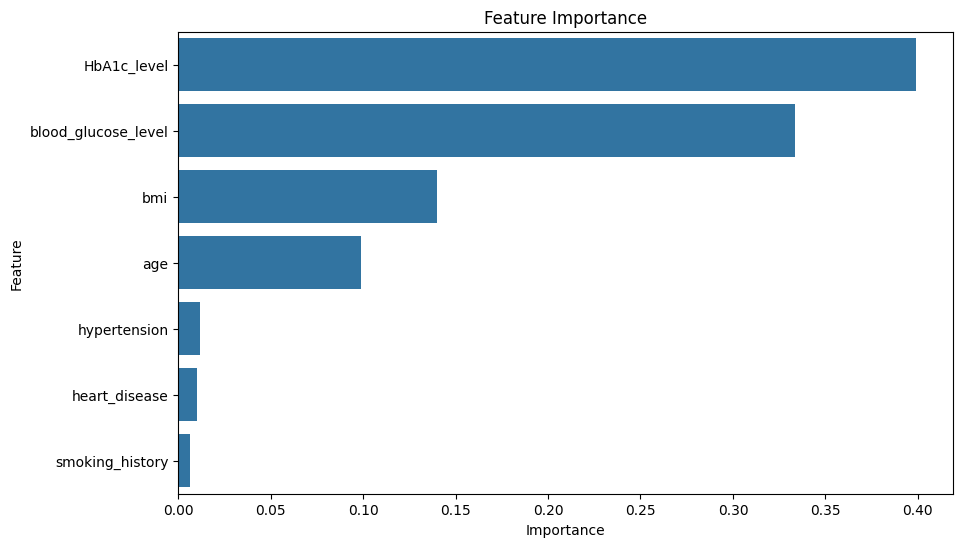

In [ ]:
# Assuming 'model' is your trained tree-based model
importances = model.feature_importances_
feature_names = X_train.columns  # Assuming X_train has feature names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

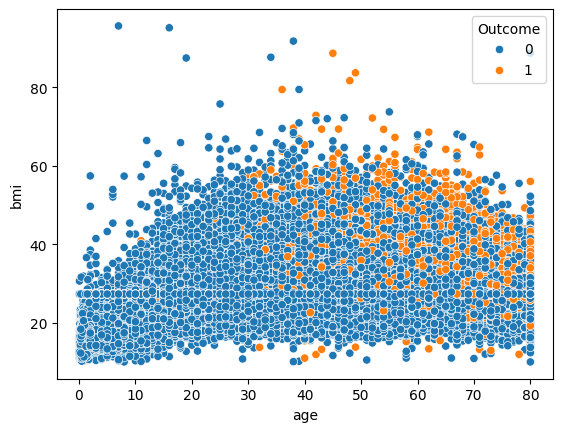

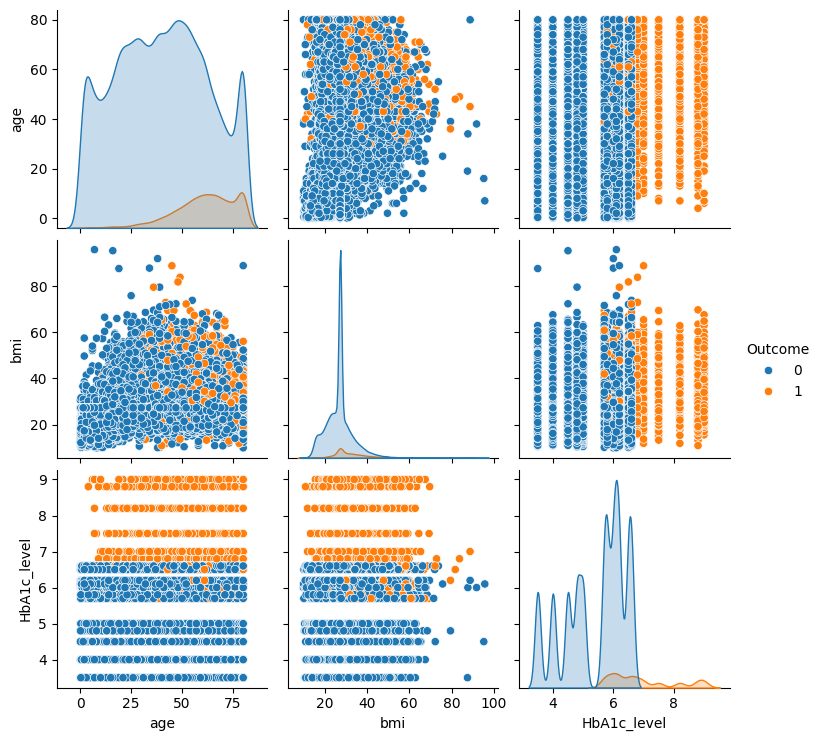

In [ ]:
# Scatter plot for two features - Replace 'feature1', 'feature2' with actual column names
sns.scatterplot(x='age', y='bmi', hue='Outcome', data=df)
plt.show()

# Pair plot for multiple features - Replace 'feature1', 'feature2', 'feature3' with actual column names
sns.pairplot(df, hue='Outcome', vars=['age', 'bmi', 'HbA1c_level'])  # Select features
plt.show()


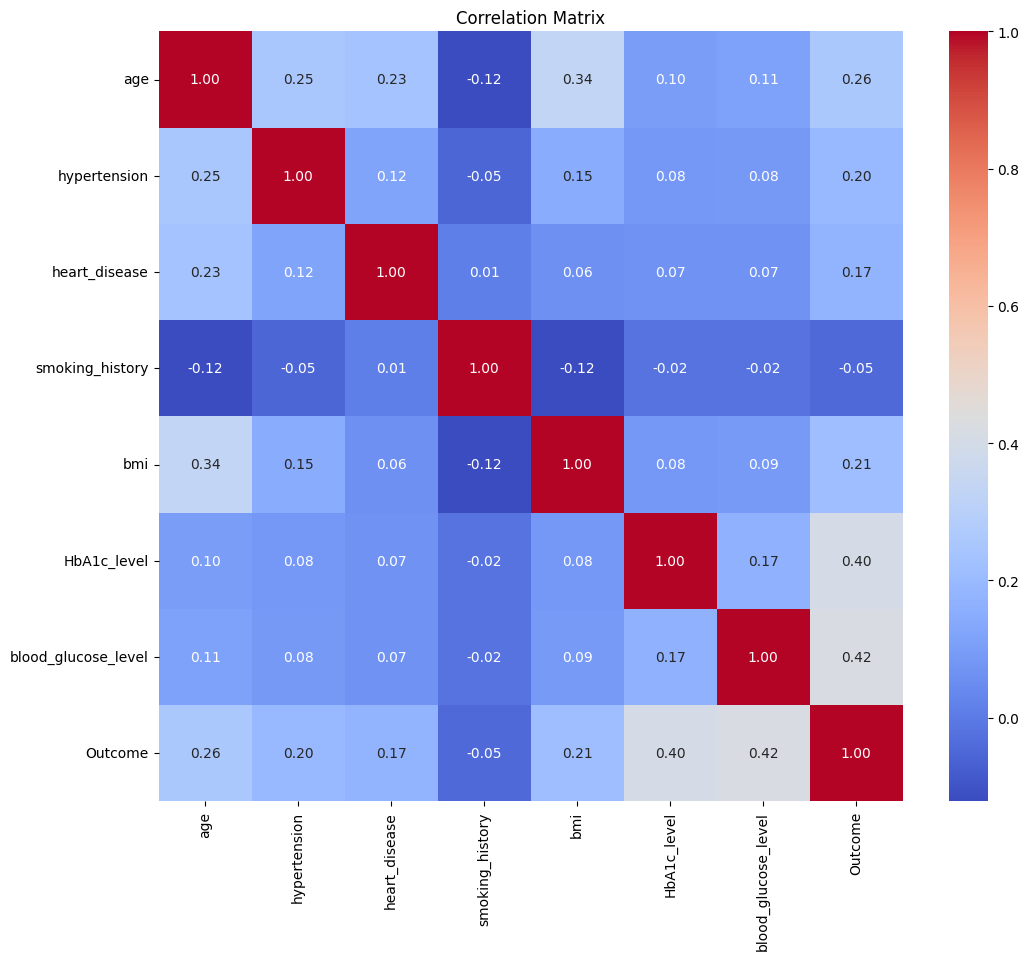

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

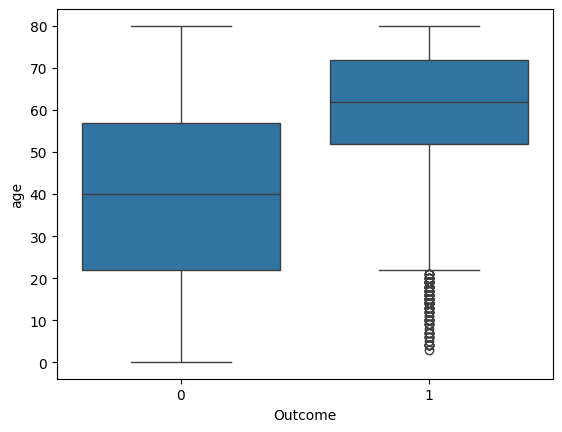

In [ ]:
# Replace 'your_actual_column_name' with the name of the column from your dataframe
sns.boxplot(x='Outcome', y='age', data=df)
plt.show()

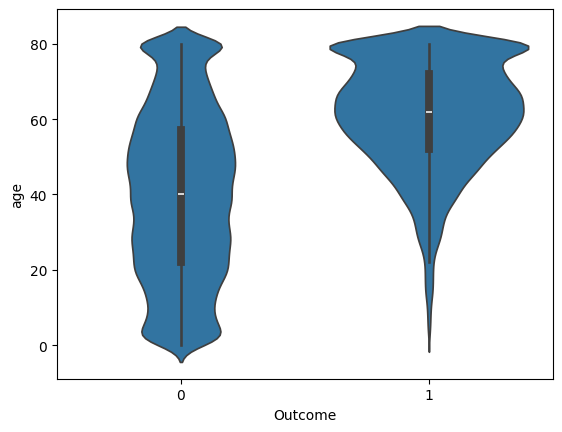

In [ ]:
# Replace 'feature1' with the actual name of the feature column in your DataFrame
sns.violinplot(x='Outcome', y='age', data=df)  # Example: Assuming 'age' is a feature column
plt.show()

In [ ]:
from diagrams import Diagram, Cluster, Edge
from diagrams.custom import Custom

with Diagram("LSTM Network Computational Graph", show=False, direction="LR"):
    # Input Layer
    input_layer = Custom("Input Layer\n(samples, 1, features)", "")

    # LSTM Layer
    lstm_layer = Custom("LSTM Layer\n(100 units)", "")

    # Dropout Layer
    dropout_layer = Custom("Dropout Layer\n(0.2)", "")

    # Dense Layer (1)
    dense_layer_1 = Custom("Dense Layer\n(25 units, ReLU)", "")

    # Dense Layer (2)
    dense_layer_2 = Custom("Dense Layer\n(1 unit, sigmoid)", "")

    # Connections
    input_layer >> Edge(label="(samples, 1, features)") >> lstm_layer
    lstm_layer >> Edge(label="(samples, 100)") >> dropout_layer
    dropout_layer >> Edge(label="(samples, 100)") >> dense_layer_1
    dense_layer_1 >> Edge(label="(samples, 25)") >> dense_layer_2
    dense_layer_2 >> Edge(label="(samples, 1)")

In [ ]:
import pandas as pd
from IPython.display import display, HTML

# Assuming you have your classification report in a dictionary format
# (e.g., from sklearn.metrics.classification_report)
classification_report_dict = {
    '0': {'precision': 0.85, 'recall': 0.90, 'f1-score': 0.87, 'support': 100},
    '1': {'precision': 0.92, 'recall': 0.88, 'f1-score': 0.90, 'support': 150},
    'accuracy': 0.89,
    'macro avg': {'precision': 0.88, 'recall': 0.89, 'f1-score': 0.88, 'support': 250},
    'weighted avg': {'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89, 'support': 250}
}

# Create a pandas DataFrame from the dictionary
report_df = pd.DataFrame(classification_report_dict).transpose()

# Style the DataFrame for better visualization
styled_report = report_df.style.background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score']) \
    .format("{:.2f}", subset=['precision', 'recall', 'f1-score']) \
    .set_properties(**{'text-align': 'center'}) \
    .set_caption("LSTM Classification Report")

# Remove index name before rendering
styled_report.index.name = None

# Display the styled report
# Use .to_html() instead of .render() for pandas versions without .render()
display(HTML(styled_report.to_html()))

,precision,recall,f1-score,support
0,0.85,0.90,0.87,100.000000
1,0.92,0.88,0.90,150.000000
accuracy,0.89,0.89,0.89,0.890000
macro avg,0.88,0.89,0.88,250.000000
weighted avg,0.89,0.89,0.89,250.000000
